In [2]:
import argparse
import sys
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

# argparse 설정
parser = argparse.ArgumentParser(description='VAE MNIST Example (Colab-friendly)')
parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--no-mps', action='store_true', default=False,
                    help='disables macOS GPU training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')

# Colab/Jupyter가 자동으로 전달하는 -f 등 인자를 무시하기 위해 parse_known_args 사용
args, _ = parser.parse_known_args()

# CUDA, MPS, CPU 등 디바이스 설정
args.cuda = not args.no_cuda and torch.cuda.is_available()
use_mps = not args.no_mps and torch.backends.mps.is_available()
torch.manual_seed(args.seed)

if args.cuda:
    device = torch.device("cuda")
elif use_mps:
    device = torch.device("mps")
else:
    device = torch.device("cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

# MNIST 데이터셋 로드
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        root='./data', train=True, download=True,
        transform=transforms.ToTensor()
    ),
    batch_size=args.batch_size, shuffle=True, **kwargs
)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        root='./data', train=False,
        transform=transforms.ToTensor()
    ),
    batch_size=args.batch_size, shuffle=False, **kwargs
)

# VAE 모델 정의
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)  # mu
        self.fc22 = nn.Linear(400, 20)  # logvar
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 손실함수 (재구성오차 + KL발산)
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# 학습 함수
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch,
                batch_idx * len(data),
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)
            ))
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

# 테스트(평가) 함수
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([
                    data[:n],
                    recon_batch.view(args.batch_size, 1, 28, 28)[:n]
                ])
                save_image(comparison.cpu(), f'results/reconstruction_{epoch}.png', nrow=n)
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

# 디렉토리 생성 (이미 존재하면 에러 없어도 괜찮음)
import os
os.makedirs('results', exist_ok=True)

# 실제 학습
for epoch in range(1, args.epochs + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   f'results/sample_{epoch}.png')


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 39.5MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.22MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.6MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.25MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Train Epoch: 1 [0/60000 (0%)]	Loss: 550.596191
Train Epoch: 1 [1280/60000 (2%)]	Loss: 306.821503
Train Epoch: 1 [2560/60000 (4%)]	Loss: 239.735825
Train Epoch: 1 [3840/60000 (6%)]	Loss: 219.265350
Train Epoch: 1 [5120/60000 (9%)]	Loss: 215.173080
Train Epoch: 1 [6400/60000 (11%)]	Loss: 207.980484
Train Epoch: 1 [7680/60000 (13%)]	Loss: 205.002502
Train Epoch: 1 [8960/60000 (15%)]	Loss: 195.018494
Train Epoch: 1 [10240/60000 (17%)]	Loss: 195.951401
Train Epoch: 1 [11520/60000 (19%)]	Loss: 191.046783
Train Epoch: 1 [12800/60000 (21%)]	Loss: 177.746719
Train Epoch: 1 [14080/60000 (23%)]	Loss: 173.476196
Train Epoch: 1 [15360/60000 (26%)]	Loss: 182.252762
Train Epoch: 1 [16640/60000 (28%)]	Loss: 168.943039
Train Epoch: 1 [17920/60000 (30%)]	Loss: 167.080704
Train Epoch: 1 [19200/60000 (32%)]	Loss: 163.089142
Train Epoch: 1 [20480/60000 (34%)]	Loss: 161.482941
Train Epoch: 1 [21760/60000 (36%)]	Loss: 152.580902
Train Epoch: 1 [23040/60000 (38%)]	Loss: 156.822372
Train Epoch: 1 [24320/60000 

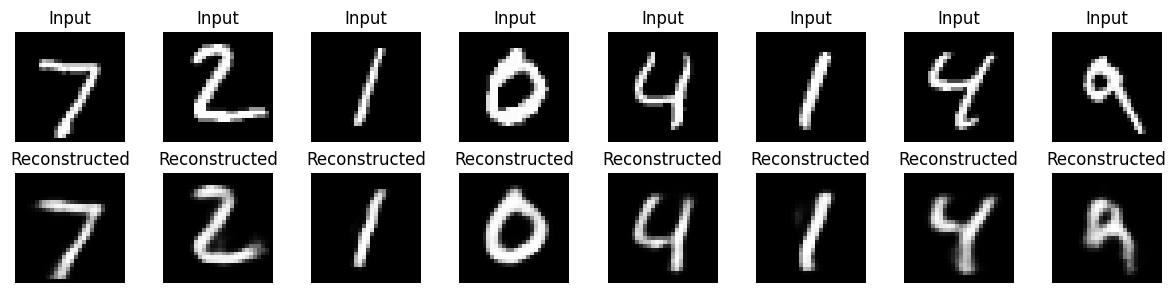

In [16]:
import matplotlib.pyplot as plt

# 모델을 평가 모드로 전환
model.eval()

# 테스트 로더에서 한 배치 가져오기
data, _ = next(iter(test_loader))
data = data.to(device)

with torch.no_grad():
    recon_batch, _, _ = model(data)

# 시각화할 이미지 개수 (예: 8장)
n = 8

# 전체 그림(fig)과 서브플롯(axes) 생성: 2행 x n열
fig, axes = plt.subplots(2, n, figsize=(n * 1.5, 3))

for i in range(n):
    # (1) 입력 이미지
    axes[0, i].imshow(data[i].cpu().squeeze(), cmap='gray')
    axes[0, i].set_title("Input")
    axes[0, i].axis('off')

    # (2) 재구성된 이미지
    recon_img = recon_batch[i].cpu().view(28, 28)
    axes[1, i].imshow(recon_img.detach(), cmap='gray')
    axes[1, i].set_title("Reconstructed")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()
